CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Homework 4 - Deep Learning - Dog Breed Identification

### *AML71: David Modjeska and Dominic Murphy*

------

# 0. Introduction

The goal of this homework assignment and Kaggle competition is to predict the breeds for a set of dog photos. The dataset originates with ImageNet, as cleaned up by Stanford University, so the foundation for prediction was solid. Our team created two models to address this challenge, as instructed: a feed-forward neural network (FFNN) and a convolutional neural network (CNN).

To prepare for modeling, we pre-processed the images in a number of steps:

1. Resized all images, and converted images for the FFNN to grayscale
2. Encoded the class labels
2. Divided the training data into training and validation subsets
3. Rebalanced the training data subset through image flipping and upsampling
4. Augmented the FFNN images through image sharpening, rotation, and warping
5. Reduced the FFNN images through PCA
6. Saved the pre-processed images and related data into pickles for future re-use

On a high level, the FFNN consists of 8 hidden layers with RELU activation, supplemented by dropout and normalization layers. The CNN consists of the well-known VGG16 model, extended and retrained with additional convolutional, dropout, and hidden layers. The FFNN was implemented in TensorFlow for learning purposes, while the CNN was implemented in Keras for classification accuracy. 

Results showed that the CNN model achieved fairly well on Kaggle - scoring in the middle of the field, broadly speaking. Multiclass log loss was approximately 2.8. The best FFNN model had a best validation accuracy of 5.99%, and a wide range of modeling techniques were explored and documented. The narrative for this model captures the details below.

The submission notebooks are cloned to the extent possible for the two models, FFNN and CNN. The shared sections include all pre-processing steps and the metrics structure (and helper functions). The code re-use attained through this discipline paid off in time savings towards the latter half of the assignment. Moreover, team communications benefitted from a shared understanding, vocabulary, and requirements.

# 1. Set up environment

#### Load packages and set display options

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import os
import re
import random
import seaborn as sns
import tensorflow as tf
import h5py
 
from os import path    
from scipy import ndimage, misc
from six.moves import cPickle as pickle

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tt_split
from sklearn.metrics import hamming_loss, f1_score, roc_curve, auc, log_loss, \
                            classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import resample, shuffle

# import keras
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, ZeroPadding2D
# from keras.optimizers import SGD, Adam
# from keras import backend as K
# from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau
# from keras.applications.vgg16 import VGG16, preprocess_input
#from keras import metrics

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display, HTML, Markdown, Image
%matplotlib inline

cache_dir = ''

In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

#### Set global constants for modeling

In [3]:
# input image dimensions
img_rows, img_cols = 128, 128

# smaller batch size means noisier gradient, but more updates per epoch
#Dom: keep high for laptop, lower for AWS
batch_size = 64

# number of iterations over the complete training data
epochs = 10

# how to split the training data among training vs. validation sets
train_ratio = 0.75

# limit the number of images that are processed during project's model exploration phase
n_image_cap = np.inf

# number of principal components to use in data reduction
# this number must be a square in order for sample image display to work 
n_pcs_to_use = 256

# model_type can be either 'cnn' or 'ffnn'
model_type = 'ffnn'

cache_dir = ''

# 2. Load and Explore Class Labels

### Load and clean class labels

In [4]:
labels_data = pd.read_csv( './labels.csv', names = ['kaggle_id', 'breed'], header = 0)
labels_data.breed = labels_data.breed.str.title()

##### Snippet of training data

In [5]:
my_linespace()
my_display_df(labels_data.head())

kaggle_id,breed
000bec180eb18c7604dcecc8fe0dba07,Boston_Bull
001513dfcb2ffafc82cccf4d8bbaba97,Dingo
001cdf01b096e06d78e9e5112d419397,Pekinese
00214f311d5d2247d5dfe4fe24b2303d,Bluetick
0021f9ceb3235effd7fcde7f7538ed62,Golden_Retriever


#### Sample of class labels

In [6]:
class_labels = labels_data.breed.unique()
print()
print(*class_labels[:20], sep = ', ')


Boston_Bull, Dingo, Pekinese, Bluetick, Golden_Retriever, Bedlington_Terrier, Borzoi, Basenji, Scottish_Deerhound, Shetland_Sheepdog, Walker_Hound, Maltese_Dog, Norfolk_Terrier, African_Hunting_Dog, Wire-Haired_Fox_Terrier, Redbone, Lakeland_Terrier, Boxer, Doberman, Otterhound


#### Summary of image counts by breed

In the summary statistics, histogram, and bar chart below, the most interesting thing to notice is the class is the class imbalance: class labels per breed span a range from 66 through 120, with a mean around 85. Clearly some sort of upsampling or rebalancing is required. Our approach will be explained below in connection with image flipping.

In [7]:
counts = labels_data.breed.value_counts()
counts_df = pd.DataFrame({'breed':counts.index, 'count':counts}).reset_index(drop = True)
counts_df.describe()

,count
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000


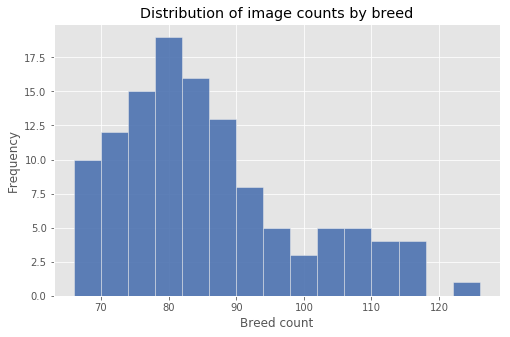

In [8]:
print()
plt.figure(figsize = (8, 5))
sns.distplot(a = counts_df['count'], bins = 15, hist = True, kde = False, 
             hist_kws={"alpha": 0.9})
plt.xlabel('Breed count')
plt.ylabel('Frequency')
plt.title('Distribution of image counts by breed')
plt.show()

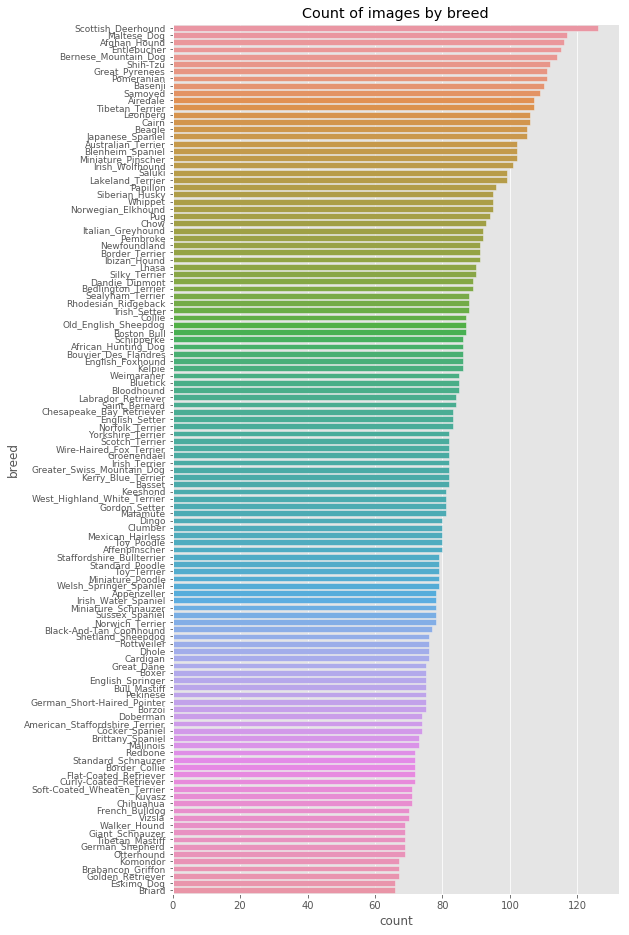

In [9]:
print()
plt.figure(figsize = (8, 16))
ax = plt.subplot(1, 1, 1)
sns.barplot(y = 'breed', x = 'count', data = counts_df)
plt.title('Count of images by breed')
ax.set_yticklabels(labels = counts_df.breed, fontsize=9)
plt.show()

# 3. Load and Preprocess Images

#### Load and resize images

The training or testing images are loaded from disk in one large code loop per set, in the code below. After loading each image, it is resized to 128 x 128 pixels and reshaped for modeling. Images for the FFNN are also converted to grayscale, as a kind of 'smart' flattening to one layer. Each image is added to a master list after this processing, and each image's ID is taken from the filename and inserted into a parallel list. This ID list will be used to synchronize the class labels data with the loaded imagery. Finally, each image is normalized through division by 255, in order to ensure that all data values lie between 0.0 and 1.0.

In [10]:
def load_process_images(image_dir):
    is_color = (model_type == 'cnn')
    
    #----- prepare for loading
    
    images = []
    image_ids = []

    image_dir = './' + image_dir + '/'
    
    image_filenames = os.listdir(image_dir)
    if (image_dir is 'train') and (labels_data.shape[0] != len(image_filenames)):
        print("Number of training labels doesn't match number of training images on disk")

    #----- load and resize images
    
    n_images = min(n_image_cap, len(image_filenames))
    for i in range(n_images):

        # get image and id from disk
        filename = image_filenames[i]
        image = cv2.imread(image_dir + filename)
        id = re.sub('.jpg', '', filename)

        image = cv2.resize(image, (img_rows, img_cols))
        if is_color:
            image = np.array(image).reshape((3, img_rows, img_cols))            
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)            

        # add image and id to list
        images.append([image])
        image_ids.append(id)

    #----- collect the image list into an array

    x = np.array(images) 
    if is_color: # add new dimension to array
        x = x[:, 0, :, :]
    images = None
    image_ids_df = pd.DataFrame({'id': image_ids })
    
    if is_color: # assumes TensorFlow as backend, so scalar for # dimensions is last
        x = x.reshape(x.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 3)
    else:
        x = x.reshape(x.shape[0], img_rows, img_cols) 
        input_shape = (img_rows, img_cols) 
        
    #----- center and normalize images
    
    # normalize image values to [0,1] (Keras sample code doesn't center)
    x = x.astype('float32')
    x /= 255 # standardization

    # display status
    print()
    print('After loading ' + image_dir + ' directory:')
    print('\tLoaded', len(image_ids), 'images from disk')
    print('\tx shape:', x.shape)
    print('\t' + str(x.shape[0]) + ' samples processed')        
        
    return(x, image_ids, input_shape)

#### Encode y

The class labels for the training data are loaded separately. These labels are then inner-joined with the already-loaded images, using image ID as the join key. After this merge, class labels are encoded as digits and then one-hot encoded for modeling.

In [11]:
# construct y for classification (TO DO: verify synchronization of labels with images)
def encode_y(x_ids, labels_data):
    x_ids_df = pd.DataFrame(x_ids, columns = ['id'])
    y_0 = pd.merge(left = x_ids_df, right = labels_data , left_on = 'id', right_on = 'kaggle_id')
    y_0 = y_0.breed.values 

    label_encoder = LabelEncoder()
    label_encoder.fit(y_0)
    y_1 = label_encoder.transform(y_0).reshape(-1, 1)

    one_hot_encoder = OneHotEncoder(sparse = False)
    one_hot_encoder.fit(y_1)
    y = one_hot_encoder.transform(y_1)

    num_labels = y.shape[1]
    
    return(y, label_encoder, one_hot_encoder, num_labels)

#### Split training data into train and validation sets

In [12]:
# split training x and y into train and validation sets
def split_my_training_data(x, y):
    x_train, x_valid, y_train, y_valid, = tt_split(x, y, train_size = train_ratio, test_size = 1.0 - train_ratio, 
                                                   shuffle = True)

    print()
    print('After splitting training data:')
    print()
    print('\tx_train shape: ' + str(x_train.shape))
    print('\tx_valid shape: ' + str(x_valid.shape))

    print()
    print('\ty_train shape: ' + str(y_train.shape))
    print('\ty_valid shape: ' + str(y_valid.shape))
    
    return(x_train, x_valid, y_train, y_valid)

#### Rebalance the classes with up-sampling from flipped images

In order to address the two-to-one class imabalance, we upsampled the minority classes to the size of the majority class through image flipping. Color images were flipped using the opencv package, while B/W images were flipped using NumPy. The resulting images were appended to the training data, along with the relevant class labels. We should note that neither the validation data nor the testing data were touched during this upsampling process.

In [13]:
#move from one hot encoding back to single column per row with class index number
def one_hot_decode(y):
    return(np.argmax(y, axis = -1))

In [14]:
# adds flipped images to minority classes to balance the training set
# Example: x_train, y_train = class_balance_with_image_flip( x_train, y_train )
# TO DO: for very unbalanced classes, oversample using both flipped and original images
def class_balance_with_image_flip( x_train, y_train, is_color = True):
    
    #move from one hot encoding back to single column per row with class index number
    y_train_decode = one_hot_decode(y_train)

    #get counts by class index
    counts = np.unique(y_train_decode, return_counts=True)

    #find number of images are in the majority class
    max_class_count = np.max(counts[1])

    flipped_x_list = []
    flipped_y_idx_list = []

    for i_class in counts[0]:

        #get original images for the class
        class_imgs = x_train[np.where(y_train_decode == i_class )]
        
        #find the number of images we needed to balance the class
        n_original = len(class_imgs) 
        n_target = max_class_count - n_original
        
        #Flip the original images to create new images
        i_row = 0
        for i in range(n_target):
            
            #horizontaly flip the original image              
            if is_color :
                image = cv2.flip( class_imgs[i_row], 1 )   
                image = np.array(image).reshape((img_rows, img_cols, 3))
            else: #BW   
                image = np.flip(class_imgs[i_row], axis = 1)
                image = np.array(image).reshape((img_rows, img_cols))

            flipped_x_list.append(image)   
            flipped_y_idx_list.append(i_class)

            #loop back to first class image if we have exceed the number of original images
            i_row += 1
            if i_row >= n_original:
                i_row = 0

    if len(flipped_x_list) > 0:           
        
        #gather flipped images
        x_flipped = np.array(flipped_x_list) 

        y_flipped_decode = np.array(flipped_y_idx_list) # cast list to array
        y_flipped = one_hot_encoder.transform(y_flipped_decode.reshape(-1, 1) )  

        #append to end of training set
        y_train = np.concatenate((y_train, y_flipped), axis=0)         
        x_train = np.concatenate((x_train, x_flipped), axis=0)
       
        #reshuffle to mix the original and flipped images
        x_train, y_train = shuffle(x_train, y_train, random_state = 0)
   
    print()
    print (len(flipped_x_list),' image(s) flipped and added')
    return(x_train, y_train);

#### Add transformed images to training data

In [15]:
# from https://www.cc.gatech.edu/classes/AY2015/cs4475_summer/documents/sharpen.py

def sharpen_image(image):
    image2 = image
    
    # Create the identity filter, but with the 1 shifted to the right
    kernel = np.zeros( (9,9), np.float32)
    kernel[4,4] = 2.0   # Identity times two

    # Create a box filter:
    boxFilter = np.ones( (9,9), np.float32) / 81.0

    # Subtract the two:
    kernel = kernel - boxFilter

    # Note that we are subject to overflow and underflow here...but I believe that
    # filter2D clips top and bottom ranges on the output, plus you'd need a
    # very bright or very dark pixel surrounded by the opposite type.
    image2 = cv2.filter2D(image, -1, kernel)

    return(image2)

In [16]:
def rotate_image(image):
    degrees = 5
    M = cv2.getRotationMatrix2D((img_cols/2, img_rows/2), degrees, 1)
    image2 = cv2.warpAffine(image, M, (img_cols, img_rows))
    
    return(image2)

In [17]:
# from https://docs.opencv.org/3.1.0/da/d6e/tutorial_py_geometric_transformations.html

def warp_image(image):
    points1 = np.float32([[25,25],[100,25],[25,100]])
#    points2 = np.float32([[5,50],[100,25],[50,125]])
    points2 = np.float32([[15,37],[100,25],[37,110]])
    
    M = cv2.getAffineTransform(points1, points2)
    
    image2 = cv2.warpAffine(image, M, (img_cols, img_rows))
    return(image2)

In [18]:
# TO DO: adapt for color images also
def add_transformed_images(x_train, y_train):
    sharpened_x_list = []
    
    # add sharpened images
    for i in range(x_train.shape[0]):
        image2 = sharpen_image(x_train[i, :])
        sharpened_x_list.append(image2)  

    # add rotated images
    for i in range(x_train.shape[0]):
        image3 = rotate_image(x_train[i, :])
        sharpened_x_list.append(image3) 
    
    # add warped images
    for i in range(x_train.shape[0]):    
        image4 = rotate_image(x_train[i, :])
        sharpened_x_list.append(image4)         
        
    x_sharpened = np.array(sharpened_x_list)       
    x_train = np.vstack((x_train, x_sharpened))
       
    # adjust y for added images
    y_train = np.vstack((y_train, y_train, y_train, y_train)) 

    x_train, y_train = shuffle(x_train, y_train, random_state = 0)
   
    print()
    print (len(sharpened_x_list),' image(s) transformed and added')
    
    return(x_train, y_train);

In [19]:
# image_dir = 'train/'
# image_filenames = os.listdir(image_dir)
# for i in range(1):
#     filename = image_filenames[i]
#     image = cv2.imread(image_dir + filename)
#     image = cv2.resize(image, (img_rows, img_cols))
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)       
# image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 

# plt.imshow(image)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis  
# plt.show()

# image2 = sharpen_image(image)
# plt.imshow(image2)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis  
# plt.show()

# image3 = rotate_image(image)
# plt.imshow(image3)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis  
# plt.show()

# image4 = warp_image(image)
# plt.imshow(image4)
# plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis  
# plt.show()

#### Reduce FFNN training data using PCA

Because the B/W images can be linearized for efficient modeling, it makes sense to apply PCA for both data reduction and a sort of regularization. Accordingly, a number of principal components was found that explained approximately 80% of the original variance, while reducing the actual data size by approximately 98%. (The scree plot below shows the tradeoff between number of principal components and variance explained.) For assignment purposes, a major benefit of applying PCA was the improvement in model training performance, which allowed additional experimentation during the time available.

In [20]:
### visualize and choose number of principal components to use
def viz_pca(pca_attribs, n_pcs_to_use):
    n_pcs_to_use = min(n_pcs_to_use, len(x_train) - 1)

    components = pca_attribs[0]
    explained_variance_ratio = pca_attribs[1]
    
    cum_var_exp = 100.0 * explained_variance_ratio.cumsum()
    plot_n_components = components.shape[0]

    # plot percentage of variance not explained
    print()
    fig = plt.figure(figsize = (8, 4))
    plt.plot(100.0 - cum_var_exp[:plot_n_components])
    plt.xticks(range(0, plot_n_components, 500))
    plt.xlabel('Number of principal components')
    plt.ylabel('% of variance not explained')
    plt.title('Scree plot for PCA\n(Showing first 1000 of 16383 components)')
    plt.show()

    # print cumlative percentage of variance explained
    my_linespace()
    my_display('Percentage of variance explained by ' + 
          str(n_pcs_to_use) + 
          ' principal components: ' +
          str(round(cum_var_exp[n_pcs_to_use - 1], 2)) +
          '%')
    my_linespace()

In [21]:
def reduce_image_data(x_train, x_valid, x_test):
    
    # flatten image arrays
    x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols) 
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows * img_cols)   
    x_test = x_test.reshape(x_test.shape[0], img_rows * img_cols) 

    # create extra PC's for graphing purposes
    pca = PCA(copy = True, random_state = 0, n_components = 4 * n_pcs_to_use, 
              svd_solver = 'full')     
    pca.fit(np.vstack([x_train, x_valid]))

    # transform using PCA
    x_train = pca.transform(x_train)[:, :n_pcs_to_use]
    x_valid = pca.transform(x_valid)[:, :n_pcs_to_use]
    x_test = pca.transform(x_test)[:, :n_pcs_to_use]

    input_shape = [n_pcs_to_use]

    # display shapes of transformed data
    print()
    print('After PCA:')
    print('\tx_train shape: ' + str(x_train.shape))
    print('\tx_valid shape: ' + str(x_valid.shape))  
    print('\tx_test shape: ' + str(x_test.shape))      
      
    return(x_train, x_valid, x_test, pca)

#### Save/load preprocessed images as pickle files

To save time during modeling runs and experiments, we saved all pre-processed data to pickle files for easy reloading during future sessions. Care was needed to capture image data accurately and completely, of course, as well as to serialize the necessary parts of encoding and data reduction functions. The resuting pickle files for color images were large enough to warrant being split into two parts. (As it turns out, the S3 storage of AWS was ideal for this purpose.)

In [22]:
# save a prepared pickle file
def save_pickle(pickle_filename, save):
    try:
        f = open(pickle_filename, 'wb')
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_filename, ':', e)
        raise

    statinfo = os.stat(pickle_filename)
    print()
    print('Size of pickle file', pickle_filename, ':', statinfo.st_size)

In [23]:
# prepare and save a new pickle file
def prep_and_save_pickle_file(pickle_filename, x, y, x_ids, data_source, pca = None):    

    # prep data structure to save
    if pca != None:
        pca_explained_variance_ratio = pca.explained_variance_ratio_
        one_hot_encoder.active_features_
        label_encoder.classes_
    
    p1_num = math.ceil(len(x)/2)
    
    save = {
            'x1': x[0:p1_num],
            'x_ids': x_ids,
            'y1': y[0:p1_num]                                             if y is not None else None,
            'input_shape': input_shape,
            'pca_components': pca.components_                             if pca is not None else None,
            'pca_mean'      : pca.mean_                                   if pca is not None else None,
            'pca_explained_variance_ratio': pca.explained_variance_ratio_ if pca is not None else None,
            'encoder_labels': one_hot_encoder.active_features_            if one_hot_encoder is not None else None,
            'encoder_names' : label_encoder.classes_                      if label_encoder is not None else None
            }
    
    # save images to pickle file for future sessions    
    save_pickle(pickle_filename, save)
    
    save = {
            'x2': x[p1_num:] ,
            'y2': y[p1_num:]                                              if y is not None else None,
            }
    
    # save images to pickle file for future sessions    
    save_pickle('2_' + pickle_filename, save)
    
    print()        
    print ('Saved pickle file:', data_source, input_shape[0]) 



In [24]:
# load an existing pickle file
def load_pickle_file(pickle_filename):

    # fill data structure from loaded pickle
    with open(pickle_filename, 'rb') as f:
        save = pickle.load(f)
        x1 = save['x1']
        x_ids = save['x_ids']
        y1 = save['y1']
        input_shape = save['input_shape'],
        pca_components = save['pca_components'],
        pca_mean = save['pca_mean'],
        pca_explained_variance_ratio = save['pca_explained_variance_ratio'],
        encoder_labels = save['encoder_labels'],
        encoder_names = save['encoder_names']
        
    # fill data structure from loaded pickle
    with open('2_' + pickle_filename, 'rb') as f:
        save = pickle.load(f)
        x2 = save['x2']
        y2 = save['y2']
    
    x = np.concatenate((x1,x2), axis=0)
    y = np.concatenate((y1,y2), axis=0) if y1 is not None else None
        
    # adjust data types after pickling
    input_shape = input_shape[0]
    pca_components = pca_components[0]   
    pca_explained_variance_ratio = np.array(pca_explained_variance_ratio)
    encoder_labels = np.array(encoder_labels).T.flatten()
    
    print()
    print ('Loaded pickle file:', pickle_filename, input_shape[0])   
    
    pca_attribs = [pca_components, pca_explained_variance_ratio, pca_mean]
    return(x, y, x_ids, input_shape, pca_attribs, encoder_labels, encoder_names)

#### Top-level script to preprocess all data

The top-level script below runs all pre-processing functions as needed, according to situation. 

In [25]:
prep_filename = lambda data_source: \
    'HW4_data_' + data_source + '_' + str(img_rows) + '_' + model_type + '.pickle'
    
train_filename = prep_filename('train')
valid_filename = prep_filename('valid')
test_filename = prep_filename('test')

# pickle files don't exist yet, so preprocess data and create them
if not path.exists(train_filename) \
    or not path.exists(valid_filename) \
    or not path.exists (test_filename):

    # load and process images
    x, x_ids, input_shape = load_process_images('train')
    x_test, x_ids_test, input_shape = load_process_images('test')    
    
    # encode y
    y, label_encoder, one_hot_encoder, num_labels = encode_y(x_ids, labels_data)   
    
    # split training data
    x_train, x_valid, y_train, y_valid = split_my_training_data(x, y)
    x = y = None # free memory
    
    # rebalance classes with upsampling from flipped images
    is_color = (model_type == 'cnn')
    x_train, y_train = class_balance_with_image_flip(x_train, y_train, is_color)
    
    if not is_color:
        x_train, y_train = add_transformed_images(x_train, y_train)
        
    # reduce image data
    pca = None
    if not is_color:
        x_train, x_valid, x_test, pca = reduce_image_data(x_train, x_valid, x_test)
        pca_attribs = [pca.components_, pca.explained_variance_ratio_, pca.mean_]
        
    encoder_labels = one_hot_encoder.active_features_
    encoder_names = label_encoder.classes_
    
    # save pickle files
    prep_and_save_pickle_file(train_filename, x_train, y_train, None       , 'train', pca)
    prep_and_save_pickle_file(valid_filename, x_valid, y_valid, None       , 'valid', pca)
    prep_and_save_pickle_file(test_filename , x_test , None   , x_ids_test , 'train', pca)
    
# pickle files already exist, to load them    
else:
    x_train, y_train, _, input_shape, pca_attribs, encoder_labels, encoder_names = load_pickle_file(train_filename)
    x_valid, y_valid, _         , _, _, _, _ = load_pickle_file(valid_filename)
    x_test , y_test , x_ids_test, _, _, _, _ = load_pickle_file(test_filename)
    
    num_labels = y_train.shape[1]


Loaded pickle file: HW4_data_train_128_ffnn.pickle 128

Loaded pickle file: HW4_data_valid_128_ffnn.pickle 128

Loaded pickle file: HW4_data_test_128_ffnn.pickle 128


#### Visualization of PCA

The elbow in the scree plot below suggests using approximately 250 principal components for data reduction.

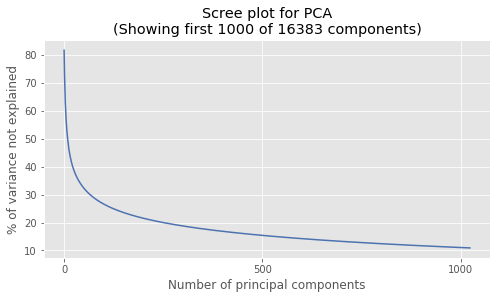

In [26]:
if model_type is 'ffnn':
    viz_pca(pca_attribs, n_pcs_to_use)
    input_shape = [x_train.shape[1]]

#### Display sample images

After such extensive pre-processing, it's essential to validate image quality and label pairing through visual inspection. While exhaustive inspection is impossible, the code below is set up to allow random inspection of twelve images and labels at a time from each of the training or validation set, as well as twelve images at a time from the testing set. The B/W images must be reconstituted from PCA-reduced form (as well as renormalized) for display. Inspection results during multiple runs for all data sets showed no obvious problems, so we proceeded with modeling on this foundation.

In [27]:
def renormalize_image(x):
    x_adjust = np.amin(x)
    if x_adjust < 0:
        x += -x_adjust
        x_range = np.amax(x) - np.amin(x)
        x /= x_range

In [28]:
num_rows = 3
num_cols = 4
num_images_to_display = num_rows * num_cols

# get sample images from training data
x_display, x_display_labels_0 = resample(x_train, y_train, replace = False, n_samples = num_rows * num_cols)
x_display_labels = encoder_names[one_hot_decode(x_display_labels_0)]

# prepare b/w images for display
if model_type is not 'cnn':
    pca_components = pca_attribs[0][:n_pcs_to_use, :]
    pca_mean = pca_attribs[2]
    
    x_display = np.dot(x_display, pca_components) + pca_mean
    renormalize_image(x_display)               
    x_display = x_display.reshape(x_display.shape[0], img_rows, img_cols)

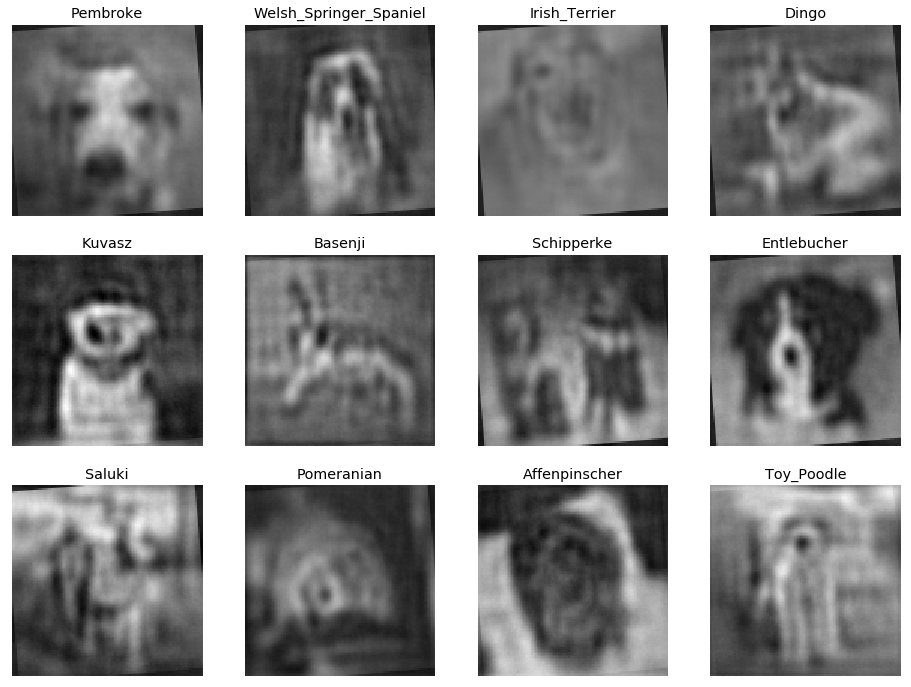

In [29]:
# code adapted from:
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html

print()
plt.figure(figsize = (16, 12))

for i in range(num_images_to_display):
    plt.subplot(num_rows, num_images_to_display/num_rows, i + 1)
    
    convert_spec = cv2.COLOR_BGR2RGB if model_type is 'cnn' else cv2.COLOR_GRAY2RGB
    image = cv2.cvtColor(x_display[i], convert_spec) 
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(x_display_labels[i])
    
plt.show()

## 4. Train FFNN Model in TensorFlow

In order to address the dog breeds classification challenge on a non-visual basis, a series of feed-forward neural networks (FFNN's) was created. This series avoided such visual mechanisms as convolutions, in order to explore the capabilities of traditional networks. Accordingly, the data was prepared with grayscale images and data reduction via PCA, as explained above. While classification accuracy could be expected to fall short of that via CNN's, the exploration is instructive *per se*.

The exploration of FFNN's included the variations listed below, building up from the simplest model towards a more sophisticated, final model:

1. single hidden layer with SGD optimization
2. two hidden layers with Adam optimization
3. four hidden layers with Adam and dropout
4. eight hidden layers with Adam and dropout
5. eight hidden layers with Adam, dropout, and batch normalization
6. eight hidden layers with Adam, dropout, normalization, and 4096 nodes per hidden layer
7. eight hidden layers with Adam, dropout, normalization, 4096 nodes, pyramidal architecture, and 64 principal components

Additional variations were explored (not shown here), including the following:

* sharpening images
* omitting data reduction (i.e., PCA)
* increasing the number of hidden layers from eight to sixteen
* increasing the dropout rate to 90%
* using a range of learning rates between 1e-1 and 1e-6
* using a range of epsilon values between 1 and 1e-8
* L2 regularization

Results consistently showed strong overfitting, which was difficult to circumvent. In the output below, increasing model sophistication raised the training accuracy from approximately 5% to approximately 98% (in longer runs). At the same time, validation accuracy rose to a maximum of 5.99%, which is not useful for practical purposes. Still, this validation accuracy is well above that of a naive classifier that always predicts randomly, which would theoretically be approximately 0.8%. 

The earlier models below use a shorter run of only 50 epochs, and a slightly higher learning rate of 1e-3, in order to demonstrate model results relatively quickly. The final model uses a longer run of 100 epochs and a learning rate of 1e-4, in order to demonstrate model results more thoroughly.

A clear finding of this process if the effectiveness of convolutions for processing images in networks, as will be discussed below.

#### Define helper functions

In [30]:
def categorical_accuracy(y_true, y_pred_proba):
    return(np.mean(np.equal(np.argmax(y_true, axis = -1), 
                            np.argmax(y_pred_proba, axis = -1))))

In [31]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev = np.sqrt(2.0 / shape[0]))
    return tf.Variable(initial, name = name)

In [32]:
def bias_variable(shape, name):
    initial = tf.zeros(shape)
    return tf.Variable(initial, name)

In [33]:
split_by_half = lambda x, k : int((x / 2) ** k)

In [34]:
def display_train_status(batch_num, l, predictions, batch_labels, use_prob = False):
    
    if not use_prob:
        valid_predict_proba = valid_prediction.eval()
    else:
        valid_predict_proba = valid_prediction.eval({keep_prob: 1.0})
    #valid_predict_proba = valid_prediction.eval()
    
    valid_labelset = tf_valid_labelset.eval()
    
    # print batch number
    print('Epoch %d:' % (batch_num))
    
    # print minibatch loss
    print('    Minibatch loss: %.2f' % (l))

    # print minibatch accuracy
    acc = categorical_accuracy(batch_labels, predictions)
    print('    Minibatch accuracy: %.2f%%' % (100.0 * acc))

    # print validation loss
    val_loss = log_loss(valid_labelset, valid_predict_proba)
    print('    Validation loss: %.2f' % val_loss)
    
    # print validation accuracy 
    val_acc = categorical_accuracy(valid_labelset, valid_predict_proba)
    print('    Validation accuracy: %.2f%%' % (100.0 * val_acc))
    print()
    
    return(acc, val_acc, valid_predict_proba)

In [35]:
# define input data.
def def_input_data(batch_size, flattened_size, num_labels):
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, flattened_size), 
                                      name = "TrainingData")
    tf_train_labelset = tf.placeholder(tf.float32, shape = (batch_size, num_labels), 
                                       name = "TrainingLabels")
    tf_valid_dataset = tf.constant(x_valid, name = "ValidationData")
    tf_valid_labelset = tf.constant(y_valid, name = "ValidationLabels")    
    
    return(tf_train_dataset, tf_train_labelset, tf_valid_dataset, tf_valid_labelset)

In [36]:
# initialize TensorFlow session
def my_init_session(graph):
    tf.global_variables_initializer().run() 
    merged = tf.summary.merge_all()  
    writer = tf.summary.FileWriter("tensorflowlogs", graph)    
    
    return(merged, writer)

#### First model: define basic NN with 1 layer and SGD optimizer

In [37]:
if model_type is not 'cnn':

    flattened_size = x_train.shape[1]
    n_hidden_nodes = 1000

    graph = tf.Graph()
    with graph.as_default():

        # define input data.
        tf_train_dataset, tf_train_labelset, tf_valid_dataset, tf_valid_labelset = \
            def_input_data(batch_size, flattened_size, num_labels)

        # define variables.
        layer1_weights = tf.Variable(tf.truncated_normal([flattened_size, num_labels]), name = "weights1")
        layer1_biases = tf.Variable(tf.zeros([num_labels]), name = "biases1")

        # define model.
        def model(data, name):
            with tf.name_scope(name) as scope:
                layer1 = tf.add(tf.matmul(data, layer1_weights), layer1_biases, name = "layer1")
                return layer1

        # define training computation.
        logits = model(tf_train_dataset, name = "logits")
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, 
                                                                      labels = tf_train_labelset), 
                              name = "loss")

        # define optimizer.
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-3).minimize(loss)

        # predict on training and validation data
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, name = "validation"))

In [38]:
def run_session_basic(num_batches, name):
    
    with tf.Session(graph = graph) as session:
        
        # initialize session
        merged, writer = my_init_session(session.graph)
        
        print("\nSession initialized\n")
        
        # run all 'epochs'
        for batch_num in range(num_batches):
            
            # define batches and input
            offset = (batch_num * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = x_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels}
            
            # run this epoch
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            
            # display loss and accuracy periodically 
            display_interval = batches_per_epoch
            if (batch_num % display_interval == 0):
                
                acc, val_acc, valid_predict_proba = display_train_status(batch_num, l, predictions, 
                                                                           batch_labels)         
        
        # package the training history
        valid_predict_proba = valid_prediction.eval()
        
    return(valid_predict_proba)

In [39]:
if model_type is not 'cnn':
    batches_per_epoch = math.ceil(y_train.shape[0] / batch_size)
    num_batches = 50 * batches_per_epoch
    y_valid_predict_proba = run_session_basic(num_batches = num_batches, name = "HW4 FFNN")


Session initialized

Epoch 0:
    Minibatch loss: 64.70
    Minibatch accuracy: 0.00%
    Validation loss: 32.33
    Validation accuracy: 1.17%

Epoch 758:
    Minibatch loss: 68.48
    Minibatch accuracy: 0.00%
    Validation loss: 32.12
    Validation accuracy: 1.06%

Epoch 1516:
    Minibatch loss: 61.94
    Minibatch accuracy: 0.00%
    Validation loss: 31.92
    Validation accuracy: 1.06%

Epoch 2274:
    Minibatch loss: 58.55
    Minibatch accuracy: 1.56%
    Validation loss: 31.73
    Validation accuracy: 1.13%

Epoch 3032:
    Minibatch loss: 54.77
    Minibatch accuracy: 3.12%
    Validation loss: 31.55
    Validation accuracy: 1.21%

Epoch 3790:
    Minibatch loss: 47.67
    Minibatch accuracy: 0.00%
    Validation loss: 31.37
    Validation accuracy: 1.29%

Epoch 4548:
    Minibatch loss: 53.42
    Minibatch accuracy: 0.00%
    Validation loss: 31.20
    Validation accuracy: 1.29%

Epoch 5306:
    Minibatch loss: 55.86
    Minibatch accuracy: 0.00%
    Validation loss: 31.0

#### Define enhanced basic NN with 2 layers and Adam optimizer

In [40]:
if model_type is not 'cnn':

    flattened_size = x_train.shape[1]
    n_hidden_nodes = 1000

    graph = tf.Graph()
    with graph.as_default():

        # define input data.
        tf_train_dataset, tf_train_labelset, tf_valid_dataset, tf_valid_labelset = \
            def_input_data(batch_size, flattened_size, num_labels)

        # define variables.
        layer1_weights = tf.Variable(tf.truncated_normal([flattened_size, n_hidden_nodes]), name = "weights1")
        layer1_biases = tf.Variable(tf.zeros([n_hidden_nodes]), name = "biases1")
        layer2_weights = tf.Variable(tf.truncated_normal([n_hidden_nodes, num_labels]), name = "weights2")
        layer2_biases = tf.Variable(tf.ones([num_labels]), name = "biases2")

        # define model.
        def model(data, name):
            with tf.name_scope(name) as scope:
                layer1 = tf.add(tf.matmul(data, layer1_weights), layer1_biases, name = "layer1")
                hidden1 = tf.nn.relu(layer1, name = "relu1")
                layer2 = tf.add(tf.matmul(hidden1, layer2_weights), layer2_biases, name = "layer2")
                return layer2 

        # define training computation.
        logits = model(tf_train_dataset, name = "logits")
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labelset), 
                              name = "loss")

        # define optimizer.
        optimizer = tf.train.AdamOptimizer(learning_rate = 1e-3, epsilon = 0.001).minimize(loss)

        # predict on training and validation data
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, name = "validation"))

In [41]:
def run_session_2_layer(num_batches, name):
    
    with tf.Session(graph = graph) as session:
        
        # initialize session
        merged, writer = my_init_session(session.graph)
        
        print("\nSession initialized\n")
        
        # run all 'epochs'
        for batch_num in range(num_batches):
            
            # define batches and input
            offset = (batch_num * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = x_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels}
            
            # run this epoch
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            
            # display loss and accuracy periodically 
            display_interval = batches_per_epoch
            if (batch_num % display_interval == 0):
                
                acc, val_acc, valid_predict_proba = display_train_status(batch_num, l, predictions, 
                                                                           batch_labels)         
        
        # package the training history
        valid_predict_proba = valid_prediction.eval()
        
    return(valid_predict_proba)

In [42]:
if model_type is not 'cnn':
    batches_per_epoch = math.ceil(y_train.shape[0] / batch_size)
    num_batches = 50 * batches_per_epoch
    y_valid_predict_proba = run_session_2_layer(num_batches = num_batches, name = "HW4 FFNN")


Session initialized

Epoch 0:
    Minibatch loss: 1242.88
    Minibatch accuracy: 0.00%
    Validation loss: 34.14
    Validation accuracy: 1.06%

Epoch 758:
    Minibatch loss: 563.21
    Minibatch accuracy: 1.56%
    Validation loss: 33.94
    Validation accuracy: 1.37%

Epoch 1516:
    Minibatch loss: 380.76
    Minibatch accuracy: 6.25%
    Validation loss: 33.86
    Validation accuracy: 1.76%

Epoch 2274:
    Minibatch loss: 276.16
    Minibatch accuracy: 9.38%
    Validation loss: 33.70
    Validation accuracy: 1.96%

Epoch 3032:
    Minibatch loss: 227.13
    Minibatch accuracy: 20.31%
    Validation loss: 33.62
    Validation accuracy: 2.31%

Epoch 3790:
    Minibatch loss: 159.81
    Minibatch accuracy: 20.31%
    Validation loss: 33.50
    Validation accuracy: 2.50%

Epoch 4548:
    Minibatch loss: 159.92
    Minibatch accuracy: 18.75%
    Validation loss: 33.47
    Validation accuracy: 2.54%

Epoch 5306:
    Minibatch loss: 108.03
    Minibatch accuracy: 28.12%
    Validati

#### Define deeper NN with 4 layers, Adam, and dropout

In [43]:
if model_type is 'ffnn':

    flattened_size = x_train.shape[1]
    n_hidden_nodes = 1000

    graph = tf.Graph()
    with graph.as_default():

        # input data
        tf_train_dataset, tf_train_labelset, tf_valid_dataset, tf_valid_labelset = \
            def_input_data(batch_size, flattened_size, num_labels)

        #----- variables.
        
        layer_1_weights = weight_variable([flattened_size, n_hidden_nodes], name = "weights_1")
        layer_1_biases = bias_variable([n_hidden_nodes], name = "biases_1")
        
        layer_2_weights = weight_variable([n_hidden_nodes, split_by_half(n_hidden_nodes,1)], name = "weights_2")
        layer_2_biases = bias_variable([split_by_half(n_hidden_nodes, 1)], name = "biases_2")
        
        layer_3_weights = weight_variable([split_by_half(n_hidden_nodes, 1), split_by_half(n_hidden_nodes,2)], name = "weights_3")
        layer_3_biases = bias_variable([split_by_half(n_hidden_nodes, 2)], name = "biases_3")
        
        layer_4_weights = weight_variable([split_by_half(n_hidden_nodes, 2), num_labels], name = "weights_4")
        layer_4_biases = bias_variable([num_labels], name = "biases_4")

        keep_prob = tf.placeholder("float", name = "keep_prob")

        # model
        def model(data, name, proba = keep_prob):
            with tf.name_scope(name) as scope:
                
                layer_1 = tf.add(tf.matmul(data, layer_1_weights), layer_1_biases, name = "layer1")
                hidden_1 = tf.nn.dropout(tf.nn.relu(layer_1), proba, name = "dropout_1")  
                
                layer_2 = tf.add(tf.matmul(hidden_1, layer_2_weights), layer_2_biases, name = "layer2") 
                hidden_2 = tf.nn.dropout(tf.nn.relu(layer_2), proba, name = "dropout_2")
                
                layer_3 = tf.add(tf.matmul(hidden_2, layer_3_weights), layer_3_biases, name = "layer3")
                hidden_3 = tf.nn.dropout(tf.nn.relu(layer_3), proba)
                
                layer_4 = tf.add(tf.matmul(hidden_3, layer_4_weights), layer_4_biases, name = "layer4")
                return layer_4
    
        # training computation.
        logits = model(tf_train_dataset, "logits", keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labelset), 
                              name = "loss")

        # optimizer.
        optimizer_0 = tf.train.AdamOptimizer(learning_rate = 1e-3, epsilon = 0.001)
        optimizer = optimizer_0.minimize(loss)

        # predictions on training and validation data
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, name = "validation"))

In [44]:
def run_session_4_layer(num_batches, name):
    
    with tf.Session(graph = graph) as session:
        
        # initialize session
        merged, writer = my_init_session(session.graph)
        
        print("\nSession initialized\n")
        
        # run all 'epochs'
        for batch_num in range(num_batches):
            
            # define batches and input
            offset = (batch_num * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = x_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : 0.7 }
            
            # run this epoch
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            
            # display loss and accuracy periodically 
            display_interval = batches_per_epoch
            if (batch_num % display_interval == 0):
                
                acc, val_acc, valid_predict_proba = display_train_status(batch_num, l, predictions, 
                                                                           batch_labels, use_prob = True)         
        
        # package the training history
        valid_predict_proba = valid_prediction.eval({keep_prob: 1.0})
        
    return(valid_predict_proba)

In [45]:
if model_type is not 'cnn':
    batches_per_epoch = math.ceil(y_train.shape[0] / batch_size)
    num_batches = 50 * batches_per_epoch
    y_valid_predict_proba = run_session_4_layer(num_batches = num_batches, name = "HW4 FFNN")


Session initialized

Epoch 0:
    Minibatch loss: 8.29
    Minibatch accuracy: 0.00%
    Validation loss: 33.26
    Validation accuracy: 0.63%

Epoch 758:
    Minibatch loss: 4.79
    Minibatch accuracy: 0.00%
    Validation loss: 4.79
    Validation accuracy: 1.06%

Epoch 1516:
    Minibatch loss: 4.79
    Minibatch accuracy: 0.00%
    Validation loss: 4.79
    Validation accuracy: 0.90%

Epoch 2274:
    Minibatch loss: 4.79
    Minibatch accuracy: 0.00%
    Validation loss: 4.79
    Validation accuracy: 0.90%

Epoch 3032:
    Minibatch loss: 4.79
    Minibatch accuracy: 3.12%
    Validation loss: 4.79
    Validation accuracy: 0.90%

Epoch 3790:
    Minibatch loss: 4.79
    Minibatch accuracy: 6.25%
    Validation loss: 4.79
    Validation accuracy: 0.90%

Epoch 4548:
    Minibatch loss: 4.79
    Minibatch accuracy: 1.56%
    Validation loss: 4.79
    Validation accuracy: 0.90%

Epoch 5306:
    Minibatch loss: 4.79
    Minibatch accuracy: 0.00%
    Validation loss: 4.79
    Validatio

#### Define 8-layer NN with Adam and dropout

In [46]:
if model_type is 'ffnn':

    flattened_size = x_train.shape[1]
    n_hidden_nodes = 1000

    graph = tf.Graph()
    with graph.as_default():

        # input data
        tf_train_dataset, tf_train_labelset, tf_valid_dataset, tf_valid_labelset = \
            def_input_data(batch_size, flattened_size, num_labels)

        #----- variables.
        
        layer_1_weights = weight_variable([flattened_size, n_hidden_nodes], name = "weights_1")
        layer_1_biases = bias_variable([n_hidden_nodes], name = "biases_1")
        
        layer_2_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_2")
        layer_2_biases = bias_variable([n_hidden_nodes], name = "biases_2")
        
        layer_3_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_3")
        layer_3_biases = bias_variable([n_hidden_nodes], name = "biases_3")
        
        layer_4_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_4")
        layer_4_biases = bias_variable([n_hidden_nodes], name = "biases_4")
        
        layer_5_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_5")
        layer_5_biases = bias_variable([n_hidden_nodes], name = "biases_5")
        
        layer_6_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_6")
        layer_6_biases = bias_variable([n_hidden_nodes], name = "biases_6")
        
        layer_7_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_7")
        layer_7_biases = bias_variable([n_hidden_nodes], name = "biases_7") 
        
        layer_8_weights = weight_variable([n_hidden_nodes, num_labels], name = "weights_8")
        layer_8_biases = bias_variable([num_labels], name = "biases_8")         

        keep_prob = tf.placeholder("float", name = "keep_prob")

        # model
        def model(data, name, proba = keep_prob):
            with tf.name_scope(name) as scope:
                
                layer_1 = tf.add(tf.matmul(data, layer_1_weights), layer_1_biases, name = "layer1")
                hidden_1 = tf.nn.dropout(tf.nn.relu(layer_1), proba, name = "dropout_1")            
                
                layer_2 = tf.add(tf.matmul(hidden_1, layer_2_weights), layer_2_biases, name = "layer2") 
                hidden_2 = tf.nn.dropout(tf.nn.relu(layer_2), proba, name = "dropout_2")                
                
                layer_3 = tf.add(tf.matmul(hidden_2, layer_3_weights), layer_3_biases, name = "layer3")
                hidden_3 = tf.nn.dropout(tf.nn.relu(layer_3), proba, name = "dropout_3")               
                
                layer_4 = tf.add(tf.matmul(hidden_3, layer_4_weights), layer_4_biases, name = "layer4")
                hidden_4 = tf.nn.dropout(tf.nn.relu(layer_4), proba, name = "dropout_4")              
                
                layer_5 = tf.add(tf.matmul(hidden_4, layer_5_weights), layer_5_biases, name = "layer5")
                hidden_5 = tf.nn.dropout(tf.nn.relu(layer_5), proba, name = "dropout_5")
                
                layer_6 = tf.add(tf.matmul(hidden_5, layer_6_weights), layer_6_biases, name = "layer6")
                hidden_6 = tf.nn.dropout(tf.nn.relu(layer_6), proba, name = "dropout_6")
                
                layer_7 = tf.add(tf.matmul(hidden_6, layer_7_weights), layer_7_biases, name = "layer7")
                hidden_7 = tf.nn.dropout(tf.nn.relu(layer_7), proba, name = "dropout_7")     
                
                layer_8 = tf.add(tf.matmul(hidden_7, layer_8_weights), layer_8_biases, name = "layer8")
                return layer_8
    
        # training computation.
        logits = model(tf_train_dataset, "logits", keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labelset), 
                              name = "loss")

        # optimizer.
        optimizer_0 = tf.train.AdamOptimizer(learning_rate = 1e-3)
        optimizer = optimizer_0.minimize(loss)

        # predictions on training and validation data
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, name = "validation"))

In [47]:
def run_session_8_layer(num_batches, name):
    
    with tf.Session(graph = graph) as session:
        
        # initialize session
        merged, writer = my_init_session(session.graph)
        
        print("\nSession initialized\n")
        
        # run all 'epochs'
        for batch_num in range(num_batches):
            
            # define batches and input
            offset = (batch_num * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = x_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : 0.7 }
            
            # run this epoch
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            
            # display loss and accuracy periodically 
            display_interval = batches_per_epoch
            if (batch_num % display_interval == 0):
                
                acc, val_acc, valid_predict_proba = display_train_status(batch_num, l, predictions, 
                                                                           batch_labels, use_prob = True)         
        
        # package the training history
        valid_predict_proba = valid_prediction.eval({keep_prob: 1.0})
        
    return(valid_predict_proba)

In [48]:
if model_type is not 'cnn':
    batches_per_epoch = math.ceil(y_train.shape[0] / batch_size)
    num_batches = 50 * batches_per_epoch
    y_valid_predict_proba = run_session_8_layer(num_batches = num_batches, name = "HW4 FFNN")


Session initialized

Epoch 0:
    Minibatch loss: 9.79
    Minibatch accuracy: 0.00%
    Validation loss: 5.07
    Validation accuracy: 0.70%

Epoch 758:
    Minibatch loss: 4.68
    Minibatch accuracy: 1.56%
    Validation loss: 4.63
    Validation accuracy: 2.11%

Epoch 1516:
    Minibatch loss: 4.58
    Minibatch accuracy: 1.56%
    Validation loss: 4.60
    Validation accuracy: 2.35%

Epoch 2274:
    Minibatch loss: 4.30
    Minibatch accuracy: 4.69%
    Validation loss: 4.55
    Validation accuracy: 2.86%

Epoch 3032:
    Minibatch loss: 4.23
    Minibatch accuracy: 6.25%
    Validation loss: 4.61
    Validation accuracy: 2.58%

Epoch 3790:
    Minibatch loss: 4.27
    Minibatch accuracy: 1.56%
    Validation loss: 4.62
    Validation accuracy: 2.97%

Epoch 4548:
    Minibatch loss: 4.04
    Minibatch accuracy: 4.69%
    Validation loss: 4.66
    Validation accuracy: 2.86%

Epoch 5306:
    Minibatch loss: 3.87
    Minibatch accuracy: 4.69%
    Validation loss: 4.69
    Validation

#### Define 8-layer NN with Adam, dropout and batch normalization

In [49]:
if model_type is 'ffnn':

    flattened_size = x_train.shape[1]
    n_hidden_nodes = 1000

    graph = tf.Graph()
    with graph.as_default():

        # input data
        tf_train_dataset, tf_train_labelset, tf_valid_dataset, tf_valid_labelset = \
            def_input_data(batch_size, flattened_size, num_labels)

        #----- variables.
        
        layer_1_weights = weight_variable([flattened_size, n_hidden_nodes], name = "weights_1")
        layer_1_biases = bias_variable([n_hidden_nodes], name = "biases_1")
        
        layer_2_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_2")
        layer_2_biases = bias_variable([n_hidden_nodes], name = "biases_2")
        
        layer_3_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_3")
        layer_3_biases = bias_variable([n_hidden_nodes], name = "biases_3")
        
        layer_4_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_4")
        layer_4_biases = bias_variable([n_hidden_nodes], name = "biases_4")
        
        layer_5_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_5")
        layer_5_biases = bias_variable([n_hidden_nodes], name = "biases_5")
        
        layer_6_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_6")
        layer_6_biases = bias_variable([n_hidden_nodes], name = "biases_6")
        
        layer_7_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_7")
        layer_7_biases = bias_variable([n_hidden_nodes], name = "biases_7") 
        
        layer_8_weights = weight_variable([n_hidden_nodes, num_labels], name = "weights_8")
        layer_8_biases = bias_variable([num_labels], name = "biases_8")         

        keep_prob = tf.placeholder("float", name = "keep_prob")

        # model
        def model(data, name, proba = keep_prob):
            with tf.name_scope(name) as scope:
                
                layer_1 = tf.add(tf.matmul(data, layer_1_weights), layer_1_biases, name = "layer1")
                hidden_1 = tf.nn.dropout(tf.nn.relu(layer_1), proba, name = "dropout_1")
                norm_1 = tf.contrib.layers.batch_norm(hidden_1, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                
                
                layer_2 = tf.add(tf.matmul(norm_1, layer_2_weights), layer_2_biases, name = "layer2") 
                hidden_2 = tf.nn.dropout(tf.nn.relu(layer_2), proba, name = "dropout_2")
                norm_2 = tf.contrib.layers.batch_norm(hidden_2, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                 
                
                layer_3 = tf.add(tf.matmul(norm_2, layer_3_weights), layer_3_biases, name = "layer3")
                hidden_3 = tf.nn.dropout(tf.nn.relu(layer_3), proba, name = "dropout_3")
                norm_3 = tf.contrib.layers.batch_norm(hidden_3, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                 
                
                layer_4 = tf.add(tf.matmul(norm_3, layer_4_weights), layer_4_biases, name = "layer4")
                hidden_4 = tf.nn.dropout(tf.nn.relu(layer_4), proba, name = "dropout_4")
                norm_4 = tf.contrib.layers.batch_norm(hidden_4, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                 
                
                layer_5 = tf.add(tf.matmul(norm_4, layer_5_weights), layer_5_biases, name = "layer5")
                hidden_5 = tf.nn.dropout(tf.nn.relu(layer_5), proba, name = "dropout_5")
                norm_5 = tf.contrib.layers.batch_norm(hidden_5, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                 
                
                layer_6 = tf.add(tf.matmul(norm_5, layer_6_weights), layer_6_biases, name = "layer6")
                hidden_6 = tf.nn.dropout(tf.nn.relu(layer_6), proba, name = "dropout_6")
                norm_6 = tf.contrib.layers.batch_norm(hidden_6, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                  
                
                layer_7 = tf.add(tf.matmul(norm_6, layer_7_weights), layer_7_biases, name = "layer7")
                hidden_7 = tf.nn.dropout(tf.nn.relu(layer_7), proba, name = "dropout_7")     
                norm_7 = tf.contrib.layers.batch_norm(hidden_7, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0)) 
                
                layer_8 = tf.add(tf.matmul(norm_7, layer_8_weights), layer_8_biases, name = "layer8")
                return layer_8
    
        # training computation.
        logits = model(tf_train_dataset, "logits", keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labelset), 
                              name = "loss")

        # optimizer.
        optimizer_0 = tf.train.AdamOptimizer(learning_rate = 1e-3, epsilon = 0.001)
        optimizer = optimizer_0.minimize(loss)

        # predictions on training and validation data
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, name = "validation"))

In [50]:
def run_session_8_layer_norm(num_batches, name):
    
    with tf.Session(graph = graph) as session:
        
        # initialize session
        merged, writer = my_init_session(session.graph)
        
        print("\nSession initialized\n")
        
        # run all 'epochs'
        for batch_num in range(num_batches):
            
            # define batches and input
            offset = (batch_num * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = x_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : 0.7 }
            
            # run this epoch
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            
            # display loss and accuracy periodically 
            display_interval = batches_per_epoch
            if (batch_num % display_interval == 0):
                
                acc, val_acc, valid_predict_proba = display_train_status(batch_num, l, predictions, 
                                                                           batch_labels, use_prob = True)         
        
        # package the training history
        valid_predict_proba = valid_prediction.eval({keep_prob: 1.0})
        
    return(valid_predict_proba)

In [51]:
if model_type is not 'cnn':
    batches_per_epoch = math.ceil(y_train.shape[0] / batch_size)
    num_batches = 50 * batches_per_epoch
    y_valid_predict_proba = run_session_8_layer_norm(num_batches = num_batches, name = "HW4 FFNN")


Session initialized

Epoch 0:
    Minibatch loss: 5.62
    Minibatch accuracy: 0.00%
    Validation loss: 5.54
    Validation accuracy: 0.74%

Epoch 758:
    Minibatch loss: 4.86
    Minibatch accuracy: 0.00%
    Validation loss: 4.98
    Validation accuracy: 3.17%

Epoch 1516:
    Minibatch loss: 4.57
    Minibatch accuracy: 3.12%
    Validation loss: 5.21
    Validation accuracy: 3.48%

Epoch 2274:
    Minibatch loss: 4.26
    Minibatch accuracy: 3.12%
    Validation loss: 5.63
    Validation accuracy: 4.03%

Epoch 3032:
    Minibatch loss: 4.00
    Minibatch accuracy: 9.38%
    Validation loss: 6.18
    Validation accuracy: 3.91%

Epoch 3790:
    Minibatch loss: 3.95
    Minibatch accuracy: 7.81%
    Validation loss: 6.90
    Validation accuracy: 3.87%

Epoch 4548:
    Minibatch loss: 3.55
    Minibatch accuracy: 15.62%
    Validation loss: 7.59
    Validation accuracy: 3.99%

Epoch 5306:
    Minibatch loss: 3.66
    Minibatch accuracy: 12.50%
    Validation loss: 8.46
    Validati

#### Define 8-layer NN with Adam, dropout, normalization, and 4096 nodes per hidden layer

In [52]:
if model_type is 'ffnn':

    flattened_size = x_train.shape[1]
    n_hidden_nodes = 4096

    graph = tf.Graph()
    with graph.as_default():

        # input data
        tf_train_dataset, tf_train_labelset, tf_valid_dataset, tf_valid_labelset = \
            def_input_data(batch_size, flattened_size, num_labels)

        #----- variables.
        
        layer_1_weights = weight_variable([flattened_size, n_hidden_nodes], name = "weights_1")
        layer_1_biases = bias_variable([n_hidden_nodes], name = "biases_1")
        
        layer_2_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_2")
        layer_2_biases = bias_variable([n_hidden_nodes], name = "biases_2")
        
        layer_3_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_3")
        layer_3_biases = bias_variable([n_hidden_nodes], name = "biases_3")
        
        layer_4_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_4")
        layer_4_biases = bias_variable([n_hidden_nodes], name = "biases_4")
        
        layer_5_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_5")
        layer_5_biases = bias_variable([n_hidden_nodes], name = "biases_5")
        
        layer_6_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_6")
        layer_6_biases = bias_variable([n_hidden_nodes], name = "biases_6")
        
        layer_7_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_7")
        layer_7_biases = bias_variable([n_hidden_nodes], name = "biases_7") 
        
        layer_8_weights = weight_variable([n_hidden_nodes, num_labels], name = "weights_8")
        layer_8_biases = bias_variable([num_labels], name = "biases_8")         

        keep_prob = tf.placeholder("float", name = "keep_prob")

        # model
        def model(data, name, proba = keep_prob):
            with tf.name_scope(name) as scope:
                
                layer_1 = tf.add(tf.matmul(data, layer_1_weights), layer_1_biases, name = "layer1")
                hidden_1 = tf.nn.dropout(tf.nn.relu(layer_1), proba, name = "dropout_1")
                norm_1 = tf.contrib.layers.batch_norm(hidden_1, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                
                
                layer_2 = tf.add(tf.matmul(norm_1, layer_2_weights), layer_2_biases, name = "layer2") 
                hidden_2 = tf.nn.dropout(tf.nn.relu(layer_2), proba, name = "dropout_2")
                norm_2 = tf.contrib.layers.batch_norm(hidden_2, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                 
                
                layer_3 = tf.add(tf.matmul(norm_2, layer_3_weights), layer_3_biases, name = "layer3")
                hidden_3 = tf.nn.dropout(tf.nn.relu(layer_3), proba, name = "dropout_3")
                norm_3 = tf.contrib.layers.batch_norm(hidden_3, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                 
                
                layer_4 = tf.add(tf.matmul(norm_3, layer_4_weights), layer_4_biases, name = "layer4")
                hidden_4 = tf.nn.dropout(tf.nn.relu(layer_4), proba, name = "dropout_4")
                norm_4 = tf.contrib.layers.batch_norm(hidden_4, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                 
                
                layer_5 = tf.add(tf.matmul(norm_4, layer_5_weights), layer_5_biases, name = "layer5")
                hidden_5 = tf.nn.dropout(tf.nn.relu(layer_5), proba, name = "dropout_5")
                norm_5 = tf.contrib.layers.batch_norm(hidden_5, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                 
                
                layer_6 = tf.add(tf.matmul(norm_5, layer_6_weights), layer_6_biases, name = "layer6")
                hidden_6 = tf.nn.dropout(tf.nn.relu(layer_6), proba, name = "dropout_6")
                norm_6 = tf.contrib.layers.batch_norm(hidden_6, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0))                  
                
                layer_7 = tf.add(tf.matmul(norm_6, layer_7_weights), layer_7_biases, name = "layer7")
                hidden_7 = tf.nn.dropout(tf.nn.relu(layer_7), proba, name = "dropout_7")     
                norm_7 = tf.contrib.layers.batch_norm(hidden_7, center = True, scale = True,  
                                                      is_training = (keep_prob is not 1.0)) 
                
                layer_8 = tf.add(tf.matmul(norm_7, layer_8_weights), layer_8_biases, name = "layer8")
                return layer_8
    
        # training computation.
        logits = model(tf_train_dataset, "logits", keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labelset), 
                              name = "loss")

        # optimizer.
        optimizer_0 = tf.train.AdamOptimizer(learning_rate = 1e-3, epsilon = 0.001)
        optimizer = optimizer_0.minimize(loss)

        # predictions on training and validation data
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, name = "validation"))

In [53]:
def run_session_8_layer_4096(num_batches, name):
    
    with tf.Session(graph = graph) as session:
        
        # initialize session
        merged, writer = my_init_session(session.graph)
        
        print("\nSession initialized\n")
        
        # run all 'epochs'
        for batch_num in range(num_batches):
            
            # define batches and input
            offset = (batch_num * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = x_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labelset : batch_labels, keep_prob : 0.7 }
            
            # run this epoch
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            
            # display loss and accuracy periodically 
            display_interval = batches_per_epoch
            if (batch_num % display_interval == 0):
                
                acc, val_acc, valid_predict_proba = display_train_status(batch_num, l, predictions, 
                                                                           batch_labels, use_prob = True)         
        
        # package the training history
        valid_predict_proba = valid_prediction.eval({keep_prob: 1.0})
        
    return(valid_predict_proba)

In [54]:
if model_type is not 'cnn':
    batches_per_epoch = math.ceil(y_train.shape[0] / batch_size)
    num_batches = 50 * batches_per_epoch
    y_valid_predict_proba = run_session_8_layer_4096(num_batches = num_batches, name = "HW4 FFNN")


Session initialized

Epoch 0:
    Minibatch loss: 5.62
    Minibatch accuracy: 0.00%
    Validation loss: 5.54
    Validation accuracy: 1.06%

Epoch 758:
    Minibatch loss: 5.51
    Minibatch accuracy: 0.00%
    Validation loss: 6.08
    Validation accuracy: 3.01%

Epoch 1516:
    Minibatch loss: 5.26
    Minibatch accuracy: 3.12%
    Validation loss: 6.38
    Validation accuracy: 3.29%

Epoch 2274:
    Minibatch loss: 4.38
    Minibatch accuracy: 4.69%
    Validation loss: 7.17
    Validation accuracy: 3.76%

Epoch 3032:
    Minibatch loss: 4.35
    Minibatch accuracy: 14.06%
    Validation loss: 8.37
    Validation accuracy: 3.13%

Epoch 3790:
    Minibatch loss: 3.04
    Minibatch accuracy: 23.44%
    Validation loss: 10.62
    Validation accuracy: 3.17%

Epoch 4548:
    Minibatch loss: 2.60
    Minibatch accuracy: 37.50%
    Validation loss: 12.66
    Validation accuracy: 3.40%

Epoch 5306:
    Minibatch loss: 2.13
    Minibatch accuracy: 39.06%
    Validation loss: 14.40
    Val

#### Final Model: define 8-layer NN with Adam, dropout, batch normalization, 4096 nodes,  pyramidal architecture, and 64 principal components

In [37]:
# help address overfitting by reducing number of principal components used
n_pcs_to_use = 64

x_train = x_train[:, :n_pcs_to_use]
x_valid = x_valid[:, :n_pcs_to_use]

In [38]:
if model_type is 'ffnn':

    flattened_size = x_train.shape[1]
    n_hidden_nodes = 4096

    graph = tf.Graph()
    with graph.as_default():

        # input data
        tf_train_dataset, tf_train_labelset, tf_valid_dataset, tf_valid_labelset = \
            def_input_data(batch_size, flattened_size, num_labels)

        #----- variables.
        
        layer_1_weights = weight_variable([flattened_size, n_hidden_nodes], name = "weights_1")
        layer_1_biases = bias_variable([n_hidden_nodes], name = "biases_1")
        
        layer_2_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_2")
        layer_2_biases = bias_variable([n_hidden_nodes], name = "biases_2")
        
        layer_3_weights = weight_variable([n_hidden_nodes, n_hidden_nodes], name = "weights_3")
        layer_3_biases = bias_variable([n_hidden_nodes], name = "biases_3")
        
        layer_4_weights = weight_variable([int(n_hidden_nodes), int(n_hidden_nodes/2)], name = "weights_4")
        layer_4_biases = bias_variable([int(n_hidden_nodes/2)], name = "biases_4")
        
        layer_5_weights = weight_variable([int(n_hidden_nodes/2), int(n_hidden_nodes/4)], name = "weights_5")
        layer_5_biases = bias_variable([int(n_hidden_nodes//4)], name = "biases_5")
        
        layer_6_weights = weight_variable([int(n_hidden_nodes/4), int(n_hidden_nodes/8)], name = "weights_6")
        layer_6_biases = bias_variable([int(n_hidden_nodes/8)], name = "biases_6")
        
        layer_7_weights = weight_variable([int(n_hidden_nodes/8), int(n_hidden_nodes/16)], name = "weights_7")
        layer_7_biases = bias_variable([int(n_hidden_nodes/16)], name = "biases_7") 
        
        layer_8_weights = weight_variable([int(n_hidden_nodes/16), num_labels], name = "weights_8")
        layer_8_biases = bias_variable([num_labels], name = "biases_8")         

        keep_prob = tf.placeholder("float", name = "keep_prob")

        # model
        def model(data, name, proba = 1.0):
            with tf.name_scope(name) as scope:
                
                layer_1 = tf.add(tf.matmul(data, layer_1_weights), layer_1_biases, name = "layer1")
                hidden_1 = tf.nn.dropout(tf.nn.relu(layer_1), proba, name = "dropout_1")
                norm_1 = tf.contrib.layers.batch_norm(hidden_1, center = True, scale = True,  
                                                      is_training = (proba is not 1.0))                
                
                layer_2 = tf.add(tf.matmul(norm_1, layer_2_weights), layer_2_biases, name = "layer2") 
                hidden_2 = tf.nn.dropout(tf.nn.relu(layer_2), proba, name = "dropout_2")
                norm_2 = tf.contrib.layers.batch_norm(hidden_2, center = True, scale = True,  
                                                      is_training = (proba is not 1.0))                 
                
                layer_3 = tf.add(tf.matmul(norm_2, layer_3_weights), layer_3_biases, name = "layer3")
                hidden_3 = tf.nn.dropout(tf.nn.relu(layer_3), proba, name = "dropout_3")
                norm_3 = tf.contrib.layers.batch_norm(hidden_3, center = True, scale = True,  
                                                      is_training = (proba is not 1.0))                 
                
                layer_4 = tf.add(tf.matmul(norm_3, layer_4_weights), layer_4_biases, name = "layer4")
                hidden_4 = tf.nn.dropout(tf.nn.relu(layer_4), proba, name = "dropout_4")
                norm_4 = tf.contrib.layers.batch_norm(hidden_4, center = True, scale = True,  
                                                      is_training = (proba is not 1.0))                 
                
                layer_5 = tf.add(tf.matmul(norm_4, layer_5_weights), layer_5_biases, name = "layer5")
                hidden_5 = tf.nn.dropout(tf.nn.relu(layer_5), proba, name = "dropout_5")
                norm_5 = tf.contrib.layers.batch_norm(hidden_5, center = True, scale = True,  
                                                      is_training = (proba is not 1.0))                 
                
                layer_6 = tf.add(tf.matmul(norm_5, layer_6_weights), layer_6_biases, name = "layer6")
                hidden_6 = tf.nn.dropout(tf.nn.relu(layer_6), proba, name = "dropout_6")
                norm_6 = tf.contrib.layers.batch_norm(hidden_6, center = True, scale = True,  
                                                      is_training = (proba is not 1.0))                  
                
                layer_7 = tf.add(tf.matmul(norm_6, layer_7_weights), layer_7_biases, name = "layer7")
                hidden_7 = tf.nn.dropout(tf.nn.relu(layer_7), proba, name = "dropout_7")     
                norm_7 = tf.contrib.layers.batch_norm(hidden_7, center = True, scale = True,  
                                                      is_training = (proba is not 1.0)) 
                
                layer_8 = tf.add(tf.matmul(norm_7, layer_8_weights), layer_8_biases, name = "layer8")
                return layer_8
    
        # training computation.
        logits = model(tf_train_dataset, "logits", keep_prob)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labelset), 
                              name = "loss")
        
        # optimizer.
        optimizer_0 = tf.train.AdamOptimizer(learning_rate = 1e-4, epsilon = 0.001)
        optimizer = optimizer_0.minimize(loss)

        # predictions on training and validation data
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset, name = "validation", proba = 1.0))

In [39]:
def run_session_final_model(num_batches, name, k_prob = 1.0):
    
    # define the training history accumulators
    acc_hist, loss_hist, lr_hist, val_acc_hist, val_loss_hist = ([] for i in range(5))
    
    with tf.Session(graph = graph) as session:
        
        # initialize session
        merged, writer = my_init_session(session.graph)
        
        print("\nSession initialized\n")
        
        # run all 'epochs'
        for batch_num in range(num_batches):
            
            # define batches and input
            offset = (batch_num * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = x_train[offset:(offset + batch_size), :]
            batch_labels = y_train[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset : batch_data, 
                         tf_train_labelset : batch_labels, 
                         keep_prob : k_prob}
            
            # run this epoch
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict = feed_dict)
            
            # display loss and accuracy periodically
            # display_interval = 10 * round(y_train.shape[0] / batch_size)  
            display_interval = batches_per_epoch
            if (batch_num % display_interval == 0):
                
                acc, val_acc, valid_predict_proba = \
                    display_train_status(batch_num / batches_per_epoch, l, predictions, batch_labels,
                                        use_prob = True)         
                
                # accumulate training history                
                #  lr = session.run(optimizer_0._learning_rate_tensor) # SGD                  
                acc_hist.append(acc)
                loss_hist.append(l)
                lr_hist.append(session.run(optimizer_0._lr_t) )
                val_acc_hist.append(val_acc)
                val_loss_hist.append(log_loss(y_valid, valid_predict_proba))
        
        # package the training history
        valid_predict_proba = valid_prediction.eval({keep_prob: 1.0})
        training_history = {'acc':acc_hist, 'loss':loss_hist, 'lr':lr_hist, 'val_acc':val_acc_hist, 
                            'val_loss':val_loss_hist}
        
    return(valid_predict_proba, training_history)

In [40]:
if model_type is not 'cnn':
    batches_per_epoch = math.ceil(y_train.shape[0] / batch_size)
    num_batches = 100 * batches_per_epoch
    y_valid_predict_proba, training_history = run_session_final_model(num_batches = num_batches, 
                                                                      name = "HW4 FFNN", 
                                                                      k_prob = 0.7)


Session initialized

Epoch 0:
    Minibatch loss: 5.60
    Minibatch accuracy: 0.00%
    Validation loss: 5.55
    Validation accuracy: 0.82%

Epoch 1:
    Minibatch loss: 4.94
    Minibatch accuracy: 1.56%
    Validation loss: 5.00
    Validation accuracy: 2.58%

Epoch 2:
    Minibatch loss: 4.87
    Minibatch accuracy: 3.12%
    Validation loss: 4.82
    Validation accuracy: 2.82%

Epoch 3:
    Minibatch loss: 4.53
    Minibatch accuracy: 3.12%
    Validation loss: 4.74
    Validation accuracy: 3.48%

Epoch 4:
    Minibatch loss: 4.45
    Minibatch accuracy: 4.69%
    Validation loss: 4.74
    Validation accuracy: 3.79%

Epoch 5:
    Minibatch loss: 4.60
    Minibatch accuracy: 6.25%
    Validation loss: 4.73
    Validation accuracy: 4.11%

Epoch 6:
    Minibatch loss: 4.32
    Minibatch accuracy: 9.38%
    Validation loss: 4.76
    Validation accuracy: 4.62%

Epoch 7:
    Minibatch loss: 4.28
    Minibatch accuracy: 3.12%
    Validation loss: 4.76
    Validation accuracy: 4.38%

Ep

Epoch 67:
    Minibatch loss: 0.11
    Minibatch accuracy: 96.88%
    Validation loss: 9.75
    Validation accuracy: 5.83%

Epoch 68:
    Minibatch loss: 0.21
    Minibatch accuracy: 92.19%
    Validation loss: 9.78
    Validation accuracy: 5.63%

Epoch 69:
    Minibatch loss: 0.17
    Minibatch accuracy: 90.62%
    Validation loss: 9.76
    Validation accuracy: 5.99%

Epoch 70:
    Minibatch loss: 0.16
    Minibatch accuracy: 93.75%
    Validation loss: 9.84
    Validation accuracy: 5.95%

Epoch 71:
    Minibatch loss: 0.22
    Minibatch accuracy: 90.62%
    Validation loss: 9.87
    Validation accuracy: 5.28%

Epoch 72:
    Minibatch loss: 0.06
    Minibatch accuracy: 98.44%
    Validation loss: 9.95
    Validation accuracy: 5.40%

Epoch 73:
    Minibatch loss: 0.17
    Minibatch accuracy: 96.88%
    Validation loss: 10.00
    Validation accuracy: 5.48%

Epoch 74:
    Minibatch loss: 0.14
    Minibatch accuracy: 93.75%
    Validation loss: 10.11
    Validation accuracy: 5.56%

Epoch 

## 5. Train CNN Model in Keras (please see other notebook)

## 6. Score FFNN model using validation data

Metrics below show the classification results from a variety of perspectives, useful in tuning:

* multiclass log loss
* categorical accuracy
* naive classification
* F1 score
* Hamming loss
* detailed classification report

While classification effectiveness was limited for this model, its best accuracy of 5.99% was well above that of a naive classifier (below), whose accuracy was only 0.82%. In addition, the metrics in this section provide a solid basis for future work.

In [41]:
### prepare metrics calculations

valid_num_images = y_valid.shape[0]

# convert y_valid to array format
y_valid_vector = one_hot_decode(y_valid)

# convert predicted probabilities to binary 2D array
y_valid_predict_proba_binary = np.zeros([y_valid.shape[0], num_labels])
for i in range(y_valid.shape[0]):
    y_valid_predict_proba_binary[i, y_valid_vector[i]] = 1

# convert predicted probabilities to binary 1D array using softmax
y_valid_predict = np.argmax(y_valid_predict_proba, axis = -1)

#### Multiclass log loss and categorical accuracy

In [42]:
# accuracy code adapted from:
# https://datascience.stackexchange.com/questions/14415/how-does-keras-calculate-accuracy

loss = log_loss(y_valid, y_valid_predict_proba)
my_accuracy = categorical_accuracy(y_valid, y_valid_predict_proba)

print()
print('Multiclass Log Loss:', round(loss, 4))
print('Categorical Accuracy:', round(my_accuracy, 4))


Multiclass Log Loss: 10.5707
Categorical Accuracy: 0.0544


 #### Calculate true/false positive rates

In [43]:
fprs = []
tprs = []

for i in range(y_valid.shape[1]):
    fpr, tpr, threshold = roc_curve(y_valid[:, i], y_valid_predict_proba[:, i])
    fprs.append(fpr)
    tprs.append(tpr)

#### Accuracy of naive classifier that predicts randomly

In [44]:
y_naive_predict = np.floor(np.random.random(valid_num_images) / (1.0 / num_labels))
valid_naive_accu = np.sum(y_valid_vector == y_naive_predict) / valid_num_images

print()
print('Accuracy of naive classifier that predicts randomly:', round(valid_naive_accu, 4))


Accuracy of naive classifier that predicts randomly: 0.0059


#### F1 Score

In [45]:
my_f1 = f1_score(y_valid_vector, y_valid_predict, average = 'macro')
print()
print('F1 score:', round(my_f1, 4))


F1 score: 0.0483


#### Hamming Loss

In [46]:
my_hamming_loss = hamming_loss(y_valid_vector, y_valid_predict)
print()
print('Hamming loss:', round(my_hamming_loss, 4))


Hamming loss: 0.9456


#### Classification Report

In [47]:
report = classification_report(y_valid_vector, y_valid_predict, labels = encoder_labels, 
                               target_names = encoder_names)
print()
print(report)


                                precision    recall  f1-score   support

                 Affenpinscher       0.12      0.17      0.14        18
                  Afghan_Hound       0.33      0.12      0.18        25
           African_Hunting_Dog       0.03      0.04      0.03        27
                      Airedale       0.08      0.05      0.06        22
American_Staffordshire_Terrier       0.00      0.00      0.00        13
                   Appenzeller       0.04      0.06      0.05        17
            Australian_Terrier       0.06      0.04      0.05        25
                       Basenji       0.00      0.00      0.00        29
                        Basset       0.08      0.06      0.07        17
                        Beagle       0.05      0.03      0.04        31
            Bedlington_Terrier       0.23      0.24      0.23        21
          Bernese_Mountain_Dog       0.12      0.14      0.13        29
       Black-And-Tan_Coonhound       0.03      0.06      0.04 

## 7. Score CNN model using validation data (please see other notebook)

## 8. Visualize FFNN

The classification accuracy graph below confirms the overfitting diagnosis mentioned above - training accuracy rises, while validation accuracy remains level througout. The spikiness of the training accuracy curve suggests an opportunity for reducing the learning rate as well.

The ROC curve shows some progress in detecting signal, in that the curve is not entirely flat. At the same time, the area under the curve is not large enough to be useful for practical purposes.

### Training process

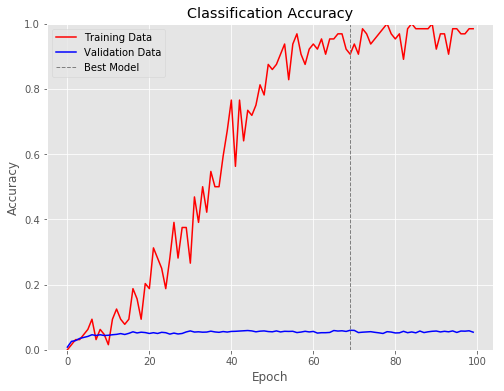

In [48]:
### plot training process - accuracy

print()
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(training_history['acc'], color = 'red', label = 'Training Data')
ax.plot(training_history['val_acc'], color = 'blue', label = 'Validation Data')
ax.set_ylim(0, 1)
ax.axvline(x=np.argmax(training_history['val_acc']),linewidth=1, linestyle='dashed', label = 'Best Model', color='grey' )
ax.legend(loc = 'upper left')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.set_title("Classification Accuracy")

plt.show()

### ROC curve for sample class

In [51]:
# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def display_roc_curve(y, predict_y_proba):
   
    fp_rate1, tp_rate1, _ = roc_curve(y, predict_y_proba)
    roc_auc1 = auc(fp_rate1, tp_rate1)

    print()
    plt.figure(figsize = (6, 6))
    plt.title('ROC AUC (Class = 8)')
    
    plt.plot(fp_rate1, tp_rate1, 'b',
    label='AUC = %0.2f'% roc_auc1)
    plt.legend(loc='lower right')
    
    plt.plot([0,1],[0,1],'r--', lw = 1)
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.show()

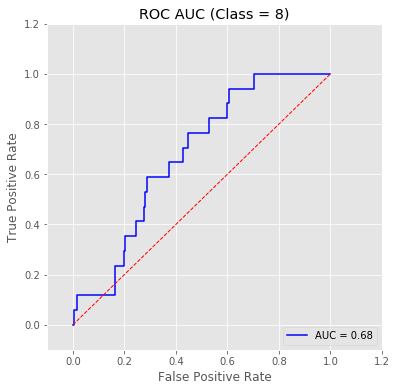

In [52]:
### ROC curve for sample class
class_num = 8
display_roc_curve(y_valid[:, class_num], y_valid_predict_proba[:, class_num])

## 9. Visualize CNN (please see other notebook)

## 10. CNN Features Learned (please see other notebook)